In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
import pickle
path_input = '/content/DS_5_train_input (1)'
path_output = '/content/DS_5_train_output (1)'
data_input = pickle.load(open(path_input, 'rb'))
data_output = pickle.load(open(path_output, 'rb'))

In [ ]:
#create pairs and for the output or second language add start and end indexes

text_pairs = []
i = 0
for string in data_output:
  data_output[i] = "[start] " + string + " [end]"
  text_pairs.append((data_input[i], data_output[i]))
  i=i+1

In [ ]:
#Create required pairs for training, validation and testing
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

In [ ]:
import tensorflow as tf
import string
import re

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 1000
sequence_length = 35

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

In [ ]:
#Define a new definition for making dataset and perform the following steps
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 35)
inputs['spanish'].shape: (64, 35)
targets.shape: (64, 35)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="english")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(
    layers.GRU(latent_dim), merge_mode="sum")(x)

In [ ]:
past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)
seq2seq_rnn = keras.Model([source, past_target], target_next_step)


In [ ]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="/gdrive/MyDrive/Colab Notebooks/dogs-vs-cats/project2_rnn_DL_BBR.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = seq2seq_rnn.fit(train_ds, epochs=30, validation_data=val_ds, callbacks = callbacks)

history_dict = history.history
history_dict.keys()

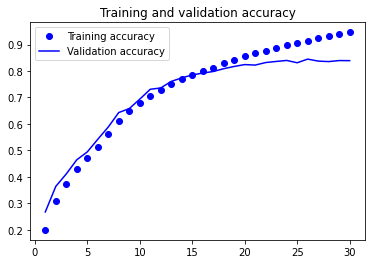

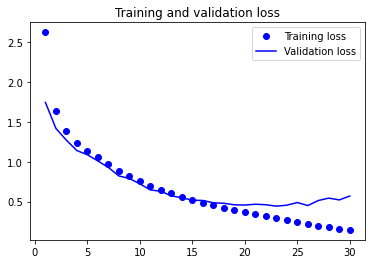

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("/gdrive/MyDrive/Colab Notebooks/dogs-vs-cats/project2_rnn_DL_BBR.keras")
seq2seq_rnn = model

import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 100

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence[7:len(decoded_sentence)-5]

test_eng_texts = [pair[0] for pair in test_pairs]

mylist = []
for i in range(len(test_eng_texts)):
    input_sentence = test_eng_texts[i]
    mylist.append(decode_sequence(input_sentence))

In [ ]:
test_ds = make_dataset(test_pairs)
model = keras.models.load_model("/gdrive/MyDrive/Colab Notebooks/dogs-vs-cats/project2_rnn_DL_BBR.keras")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

12/12 [==============================] - 4s 21ms/step - loss: 0.4312 - accuracy: 0.8379
Test accuracy: 0.838
